# Imports

In [1]:
import sys
import os
from pathlib import Path

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[0]))
sys.path.append(str(file.parents[1]))
sys.path.append(str(file.parents[2]))

In [2]:
import scipy.ndimage
import torch.nn.functional as F
import monai
from skimage.measure import find_contours
import cv2
import numpy as np
import torch
import TPTBox
from TPTBox import NII, np_utils
from utils.brats_tools import get_central_slice, plot_slices, soften_gt
import utils.fastnumpyio.fastnumpyio as fnio
from data.bids_dataset import create_bids_path_list_of_dicts
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

In [3]:
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'

train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

#  Function that plots all slices

In [4]:
def plot_all_slices(seg_mask:np.ndarray):
    for i in range(seg_mask.shape[0]):
        channel = seg_mask[i]

        xy_seg_slice = get_central_slice(channel, axis = 2)
        xz_seg_slice = get_central_slice(channel, axis = 1)
        yz_seg_slice = get_central_slice(channel, axis = 0)

        #plot all three next to each other
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(xy_seg_slice)
        ax[0].set_title('XY plane')
        ax[1].imshow(xz_seg_slice)
        ax[1].set_title('XZ plane')
        ax[2].imshow(yz_seg_slice)
        ax[2].set_title('YZ plane')

# Function that returns the boundary layer of a segmentation mask

In [43]:
def get_boundary_layer(seg_msk:np.ndarray, pixel_connectivity:int = 3):
    """"
    seg_msk: one-hot encoded 3D segmentation mask, shape (C, H, W, D)
    """
    # 1. Create empty array to store the eroded segmentation
    eroded_msk = np.zeros_like(seg_msk)

    # 2. Apply the Dilation
    for channel in range(seg_msk.shape[0]):
        eroded_msk[channel] = np_utils.np_erode_msk(seg_msk[channel], mm=1, connectivity=pixel_connectivity)

    # 3. Get the boundary by substracting the eroded mask from the og
    boundary_layer = seg_msk - eroded_msk

    return boundary_layer

# Check Behaviour at Boundary Layer

## Setting up a tensor

In [14]:
#Loading actual data
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'
train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

# 1. load image 
sample_idx = 3
img_path = train_list[sample_idx]['t1c']
seg_path = train_list[sample_idx]['seg']

img = fnio.load(str(img_path))
seg = fnio.load(str(seg_path))

# 2. transform to torch tensors (and add channel dim to img tensor)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
seg_tensor = torch.tensor(seg, dtype=torch.long)

# 3. transform seg_tensor to one hot encoding and permute the dimensions
oh_seg = F.one_hot(seg_tensor, num_classes=4)
oh_seg = oh_seg.permute(3, 0, 1, 2)

## Determining the boundary layer and softening the mask

In [47]:
# Getting the boundary layer
boundary_layer = get_boundary_layer(oh_seg.numpy(), pixel_connectivity=1)

# Softening the mask
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 5  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_oh_seg = torch.empty_like(oh_seg, dtype=torch.float32)  # Create an empty tensor to store the results

for i in range(oh_seg.shape[0]):  # Loop through each class channel
    filtered_oh_seg[i] = torch.tensor(scipy.ndimage.gaussian_filter(oh_seg[i].numpy().astype(np.float32), sigma=sigma))

masked_softened_gt = filtered_oh_seg.numpy() * boundary_layer
print(f"unique values in the masked_softened_gt: {np.unique(masked_softened_gt)}")

interior_mask = oh_seg.numpy() - boundary_layer
print(f"unique values in the interior_mask: {np.unique(interior_mask)}")

unique values in the masked_softened_gt: [0.         0.00127118 0.0016909  ... 0.98118007 0.98219776 1.        ]
unique values in the interior_mask: [0 1]


## Plotting the interior mask

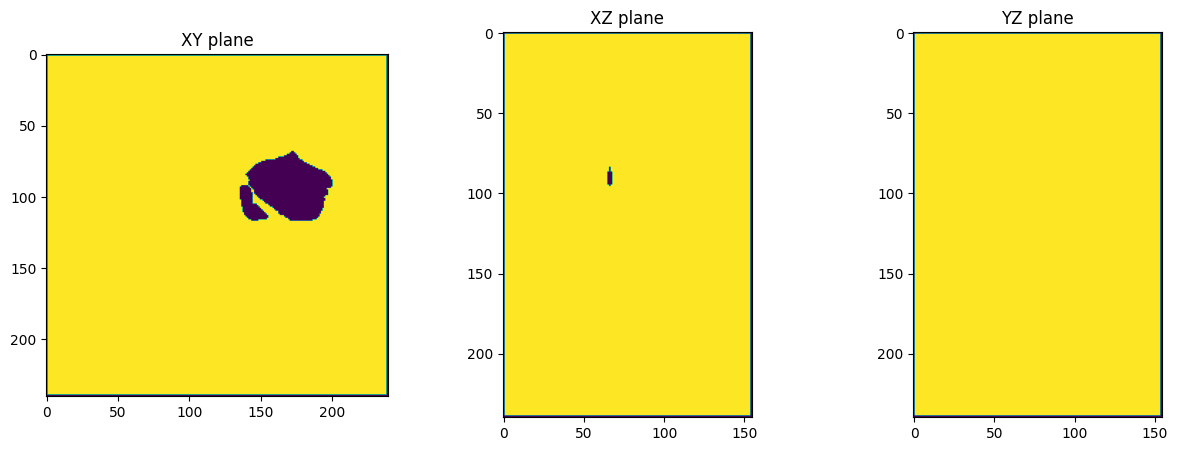

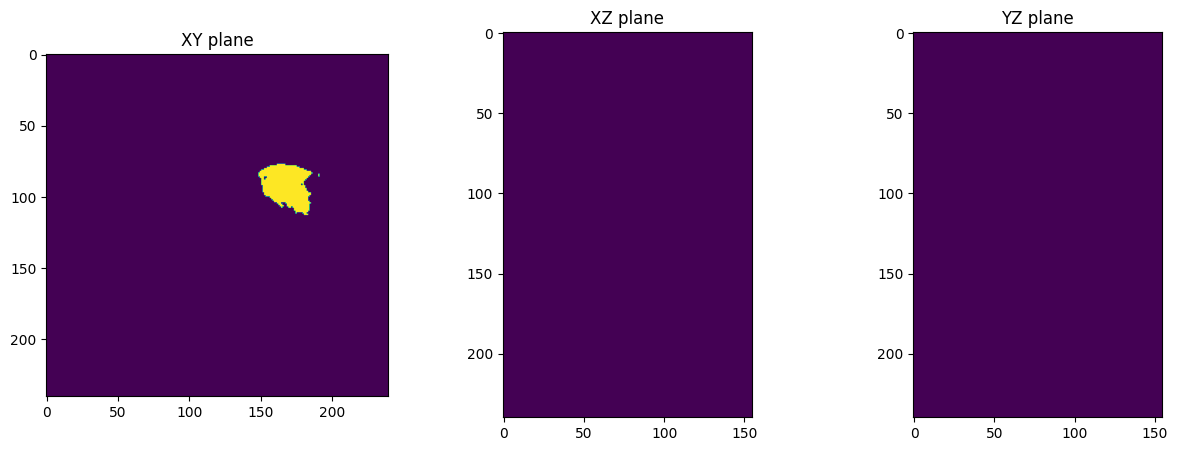

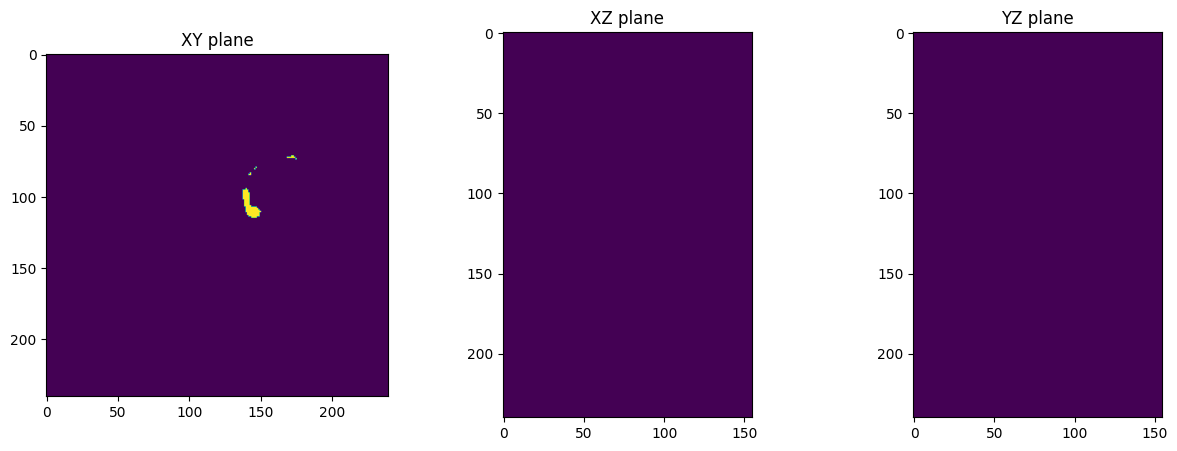

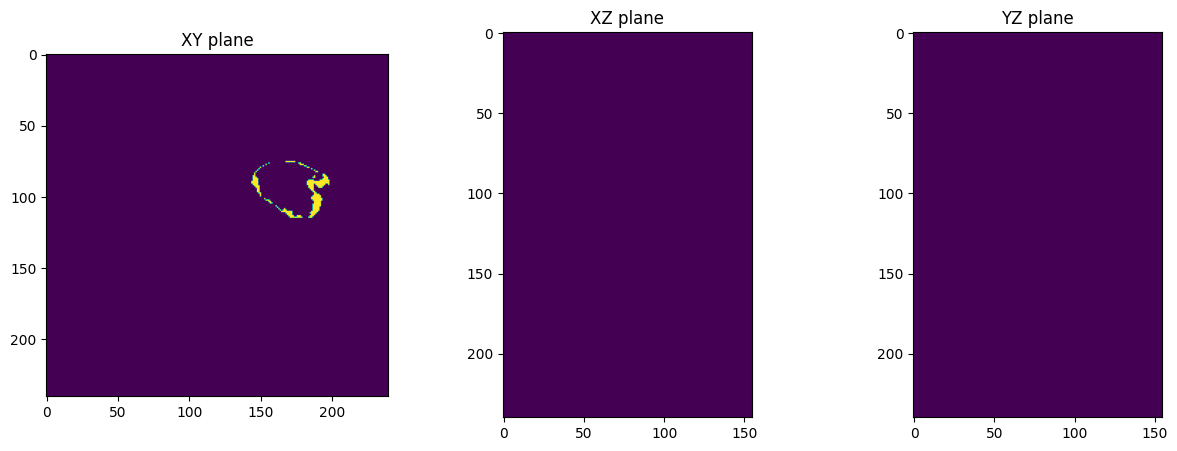

In [49]:
plot_all_slices(interior_mask)

## Plotting the boundary layer

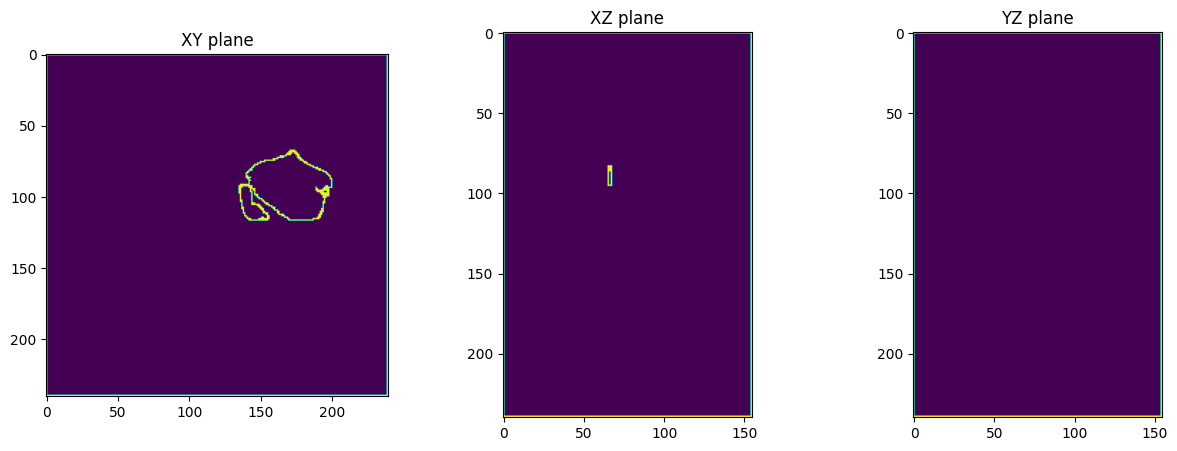

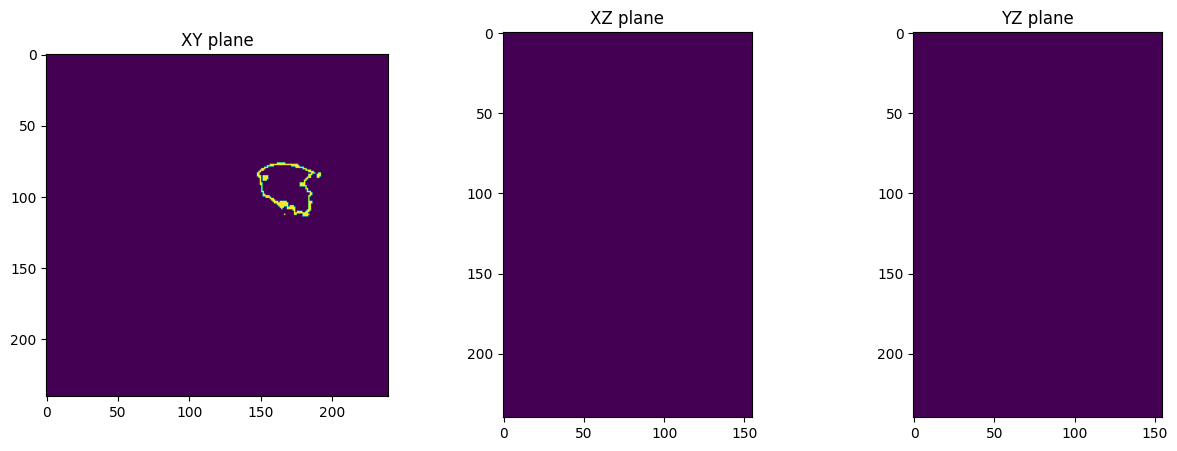

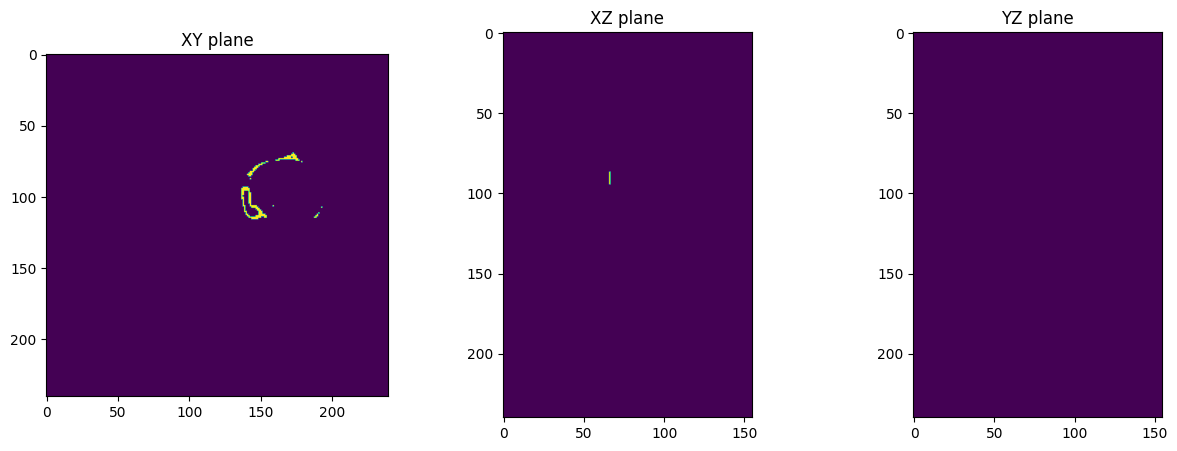

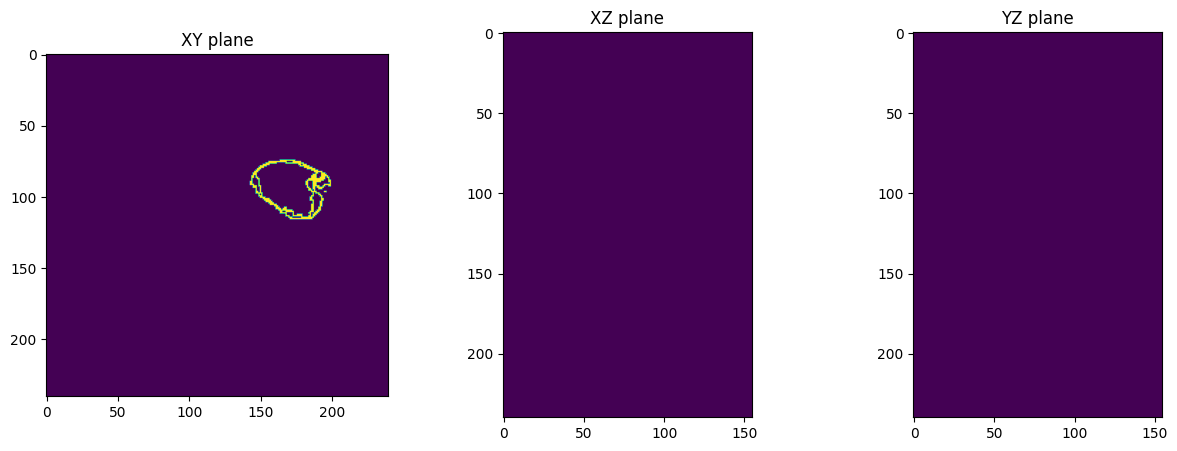

In [38]:
plot_all_slices(boundary_layer)

## Plotting the softened masks

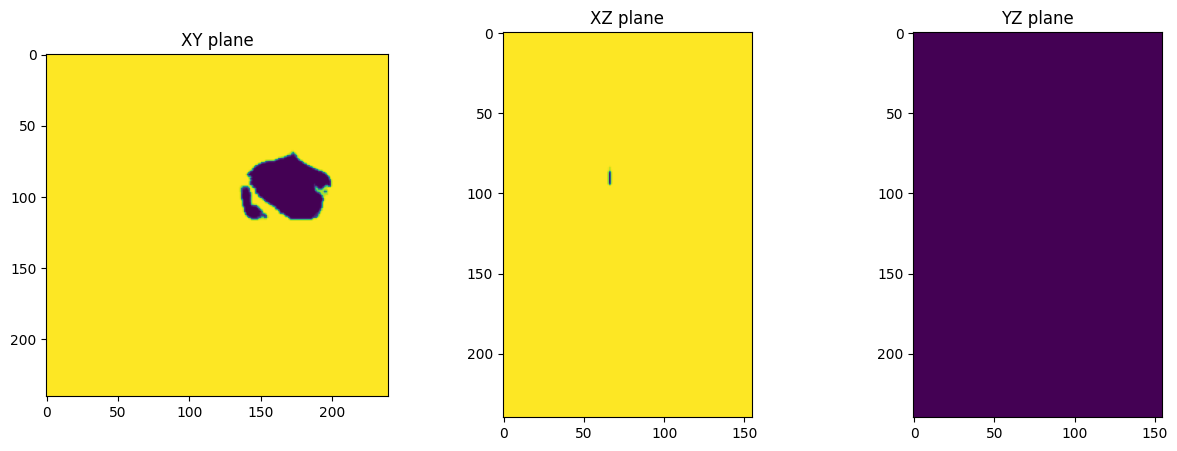

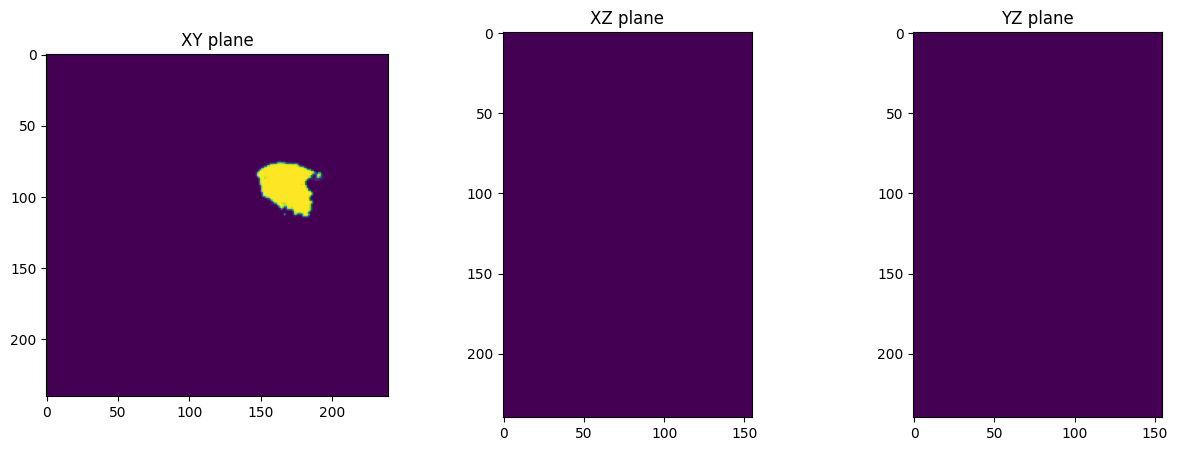

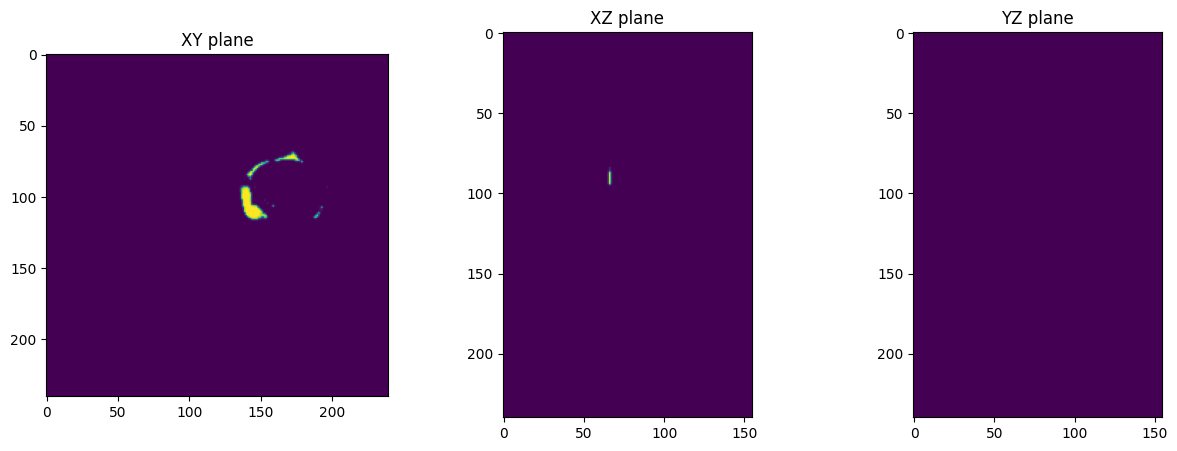

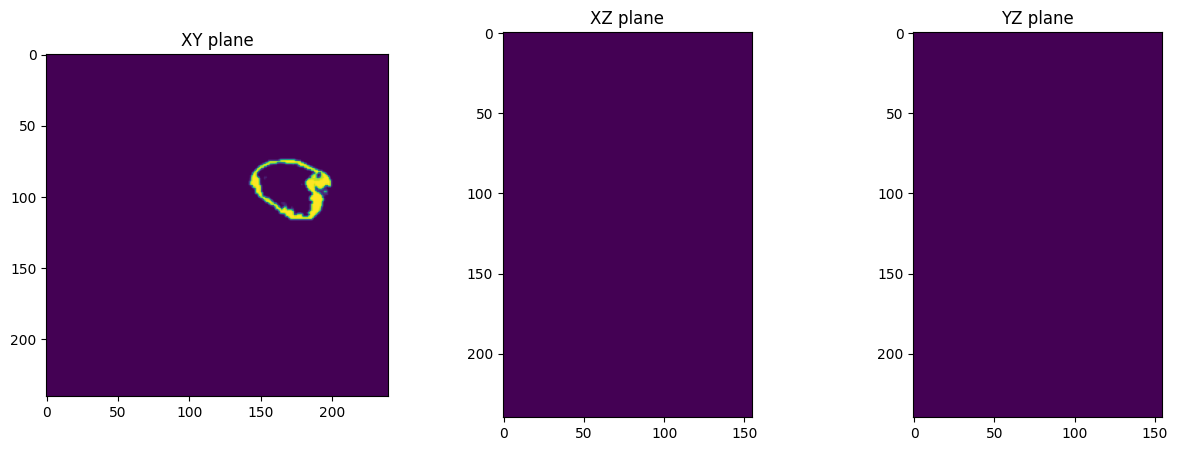

In [20]:
plot_all_slices(filtered_oh_seg.numpy())